# About the project
The work is all about tackling software effort prediction (SEP) and software test prediction (STP) (i.e., software reliability problems) by integrating a metaheuristicm algorith with a ML model to optimize the model's parameters.
Here JAYA algorithm is used in other to improve a Support Vector Regressor SVR model's predictions (predicting the Software effort). Using the Jaya algorithm to optimize the SVR parameters (C, epsilon, gamma).

- The final goal of the project is to compare the results gotten with the results published in a paper by  Sofian Kassaymeh, Salwani Abdullah, Mohamad Al-Laham and others, titled: Salp Swarm Optimizer for Modeling Software Reliability Prediction Problem.
- The same datasets are used.

In [1]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

In [2]:
# Load dataset
df = pd.read_csv("dataset/COCOMO-81.csv")
df = df.drop(["num", "dev_mode"], axis=1)
df.head()

,rely,data,cplx,time,stor,virt,turn,acap,aexp,pcap,vexp,lexp,modp,tool,sced,loc,actual
0,0.88,1.16,0.70,1.0,1.06,1.15,1.07,1.19,1.13,1.17,1.1,1.00,1.24,1.10,1.04,113.0,2040.0
1,0.88,1.16,0.85,1.0,1.06,1.00,1.07,1.00,0.91,1.00,0.9,0.95,1.10,1.00,1.00,293.0,1600.0
2,1.00,1.16,0.85,1.0,1.00,0.87,0.94,0.86,0.82,0.86,0.9,0.95,0.91,0.91,1.00,132.0,243.0
3,0.75,1.16,0.70,1.0,1.00,0.87,1.00,1.19,0.91,1.42,1.0,0.95,1.24,1.00,1.04,60.0,240.0
4,0.88,0.94,1.00,1.0,1.00,0.87,1.00,1.00,1.00,0.86,0.9,0.95,1.24,1.00,1.00,16.0,33.0


# Option 1: Run model and Predictions without Feature Selection

In [3]:
X = df.drop(columns=["actual"])
y = df["actual"]

In [4]:
# Scale features and target
scaler_x = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_x.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

In [5]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

## SVR only

In [6]:
# Running the SVR model only without JAYA optimization
model1 = SVR(C=100, epsilon=0.1, gamma=0.005)
model1.fit(X_train, y_train)
y_pred1 = model1.predict(X_test)
mse = mean_squared_error(y_test, y_pred1)
mse

0.11921545744115179

In [7]:
y_predr = scaler_y.inverse_transform(y_pred1.reshape(-1, 1))  # Reverse scaling to get the original values
y_testr = scaler_y.inverse_transform(y_test.reshape(-1, 1))
print(y_predr[:6])
print(y_testr[:6])
print("mse: ", mean_squared_error(y_testr, y_predr))

[[-1292.78740947]
 [ 1332.86632808]
 [ 1248.96435606]
 [  386.39420508]
 [  -65.27148135]
 [ -575.13006149]]
[[  38.]
 [ 130.]
 [2040.]
 [  87.]
 [  43.]
 [  47.]]
mse:  389266.8898966859


## SVR with JAYA optimization

In [8]:
def fitness_function(params, X_train, y_train):
    try:
        C, epsilon, gamma = params
        model = SVR(C=C, epsilon=epsilon, gamma=gamma)
        
        # Use cross-validation on the training set
        # train on 80% of training data, validate on 20%
        X_train_train, X_val, y_train_train, y_val = train_test_split(
            X_train, y_train, test_size=0.2, random_state=42)
        
        model.fit(X_train_train, y_train_train)
        y_pred = model.predict(X_val)
        mse = mean_squared_error(y_val, y_pred)
        return mse
    except:
        return float('inf')

In [9]:
def jaya_optimizer(fitness_fn, bounds, pop_size=10, iterations=100):
    dim = len(bounds)
    population = np.random.uniform([b[0] for b in bounds], [b[1] for b in bounds], size=(pop_size, dim))
    mse_per_iter = []

    for it in range(iterations):
        fitness_values = [fitness_fn(ind, X_train, y_train) for ind in population]
        best_idx, worst_idx = np.argmin(fitness_values), np.argmax(fitness_values)
        best, worst = population[best_idx], population[worst_idx]

        for i in range(pop_size):
            r1, r2 = np.random.rand(dim), np.random.rand(dim)
            new_ind = population[i] + r1 * (best - abs(population[i])) - r2 * (worst - abs(population[i]))
            new_ind = np.clip(new_ind, [b[0] for b in bounds], [b[1] for b in bounds])
            new_fit = fitness_fn(new_ind, X_train, y_train)
            if new_fit < fitness_values[i]:
                population[i] = new_ind

        mse_per_iter.append(min(fitness_values))

    final_fitness = [fitness_fn(ind, X_train, y_train) for ind in population]
    best_index = np.argmin(final_fitness)
    return population[best_index], final_fitness[best_index], mse_per_iter

In [10]:
# SVR hyperparameter bounds: C, epsilon, gamma
bounds = [(100, 1000), (0.05, 0.2), (0.001, 0.005)]

In [11]:
best_params, best_mse, mse_progression = jaya_optimizer(fitness_function, bounds, pop_size=10, iterations=100)

print("Best Parameters (C, epsilon, gamma):", best_params)
print("Best MSE on validation set:", best_mse)

Best Parameters (C, epsilon, gamma): [1.00000091e+02 6.83805127e-02 1.00000000e-03]
Best MSE on validation set: 0.05573547822175595


In [12]:
# Now evaluate the best model on the test set (unseen data)
best_model = SVR(C=best_params[0], epsilon=best_params[1], gamma=best_params[2])
best_model.fit(X_train, y_train)
y_test_pred = best_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
print("Test MSE on unseen data:", test_mse)

Test MSE on unseen data: 0.06444994379055655


In [13]:
y_test_predr = scaler_y.inverse_transform(y_test_pred.reshape(-1, 1))  # Reverse scaling to get the original values
y_testr = scaler_y.inverse_transform(y_test.reshape(-1, 1))
print(y_predr[:6])
print(y_testr[:6])
print("mse: ", mean_squared_error(y_testr, y_test_predr))

[[-1292.78740947]
 [ 1332.86632808]
 [ 1248.96435606]
 [  386.39420508]
 [  -65.27148135]
 [ -575.13006149]]
[[  38.]
 [ 130.]
 [2040.]
 [  87.]
 [  43.]
 [  47.]]
mse:  210444.4315515919


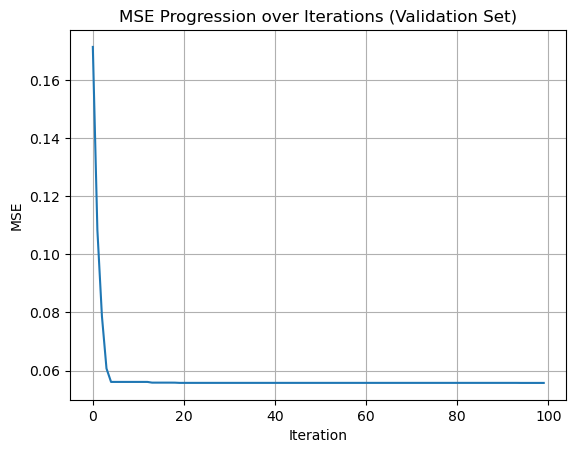

In [14]:
plt.plot(mse_progression)
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.title("MSE Progression over Iterations (Validation Set)")
plt.grid(True)
plt.show()

# Option 2: Implementing Feature Selections 

- The model's MSE value from option 1: SVR only will be used as a baseline value to see if the feature selections helps in improving the model's performance

In [15]:
df2 = df.copy()

In [16]:
df2.head()

,rely,data,cplx,time,stor,virt,turn,acap,aexp,pcap,vexp,lexp,modp,tool,sced,loc,actual
0,0.88,1.16,0.70,1.0,1.06,1.15,1.07,1.19,1.13,1.17,1.1,1.00,1.24,1.10,1.04,113.0,2040.0
1,0.88,1.16,0.85,1.0,1.06,1.00,1.07,1.00,0.91,1.00,0.9,0.95,1.10,1.00,1.00,293.0,1600.0
2,1.00,1.16,0.85,1.0,1.00,0.87,0.94,0.86,0.82,0.86,0.9,0.95,0.91,0.91,1.00,132.0,243.0
3,0.75,1.16,0.70,1.0,1.00,0.87,1.00,1.19,0.91,1.42,1.0,0.95,1.24,1.00,1.04,60.0,240.0
4,0.88,0.94,1.00,1.0,1.00,0.87,1.00,1.00,1.00,0.86,0.9,0.95,1.24,1.00,1.00,16.0,33.0


In [17]:
# Feature Selection: Step 1 -> Pearson Correlation
df2.corrwith(df['actual']).drop("actual")

rely    0.206703
data    0.444551
cplx    0.010049
time    0.152485
stor    0.104838
virt    0.018668
turn    0.205883
acap   -0.147865
aexp   -0.035519
pcap    0.156916
vexp    0.068105
lexp    0.087766
modp    0.269879
tool    0.002223
sced    0.021463
loc     0.657198
dtype: float64

In [18]:
# From the values above, dropping all the features with < 0.1
X1 = df2[["rely", "data", "time", "stor", "turn", "pcap", "modp", "loc"]]
y1 = df2["actual"]

In [19]:
# Scale features and target
X1_scaled = scaler_x.fit_transform(X1)
y1_scaled = scaler_y.fit_transform(y1.values.reshape(-1, 1)).flatten()

In [20]:
# Split dataset
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1_scaled, y1_scaled, test_size=0.2, random_state=42)

In [21]:
# Running the SVR model only without JAYA optimization
model1 = SVR(C=100, epsilon=0.1, gamma=0.005)
model1.fit(X_train1, y_train1)
y_pred_cor = model1.predict(X_test1)
mse = mean_squared_error(y_test1, y_pred_cor)
mse

0.02333671314198467

- With feature selection the new mse 0.11259 compared to the previous 0.05696, shows that the model's prediction got worse.

In [22]:
y_cor_predr = scaler_y.inverse_transform(y_pred_cor.reshape(-1, 1))  # Reverse scaling to get the original values
y_cor_testr = scaler_y.inverse_transform(y_test1.reshape(-1, 1))
print(y_cor_predr[:6])
print(y_cor_testr[:6])
print("mse: ", mean_squared_error(y_cor_testr, y_cor_predr))

[[ -60.20814123]
 [ -53.98645426]
 [1185.02732487]
 [ 274.11843192]
 [  46.91654077]
 [  34.42057718]]
[[  38.]
 [ 130.]
 [2040.]
 [  87.]
 [  43.]
 [  47.]]
mse:  76199.93195660658


In [125]:
#X1.var()

In [126]:
# Using Mutual information to see if there are any features that could be dropped also

In [23]:
col = X1.shape[1]

In [24]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

In [25]:
mse_list = []
for k in range(1, col + 1):  # loop through number of features
    selector = SelectKBest(mutual_info_regression, k=k)
    selector.fit(X_train1, y_train1)

    sel_X_train = selector.transform(X_train1)
    sel_X_test = selector.transform(X_test1)

    model1.fit(sel_X_train, y_train1)
    kbest_preds = model1.predict(sel_X_test)
    mse_kbest = round(mean_squared_error(y_test1, kbest_preds), 4)

    mse_list.append(mse_kbest)

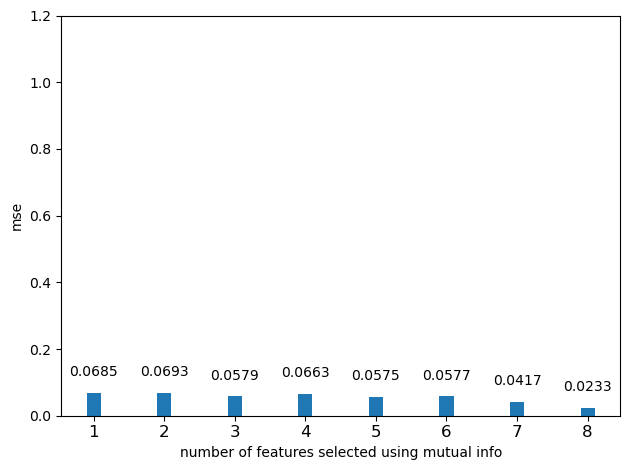

In [29]:
fig, ax = plt.subplots()

x = np.arange(1, col+1)
y = mse_list

ax.bar(x, y, width= 0.2)
ax.set_xlabel ("number of features selected using mutual info")
ax.set_ylabel ("mse")
ax.set_ylim(0, 1.2)
ax.set_xticks(np.arange(1,col+1))
ax.set_xticklabels(np.arange(1, col+1), fontsize=12)

for i, v in enumerate(y):
    plt.text(x=i+1, y=v+0.05, s=str(v), ha='center')
plt.tight_layout()

In [31]:
# top features selected
selector = SelectKBest(mutual_info_regression, k=8)
selector.fit(X_train1, y_train1)

selected_feature_mask = selector.get_support()
#X_scaled = pd.DataFrame(scaler_x.fit_transform(X), columns=X.columns)
selected_features = X1.columns[selected_feature_mask]
selected_features

Index(['rely', 'data', 'time', 'stor', 'turn', 'pcap', 'modp', 'loc'], dtype='object')

- From the plot above, there is no need for further feature selection

In [132]:
# Running the Jaya-svr optimization with new selected features

In [32]:
def jaya_optimizer(fitness_fn, bounds, pop_size=10, iterations=100):
    dim = len(bounds)
    population = np.random.uniform([b[0] for b in bounds], [b[1] for b in bounds], size=(pop_size, dim))
    mse_per_iter = []

    for it in range(iterations):
        fitness_values = [fitness_fn(ind, X_train1, y_train1) for ind in population]
        best_idx, worst_idx = np.argmin(fitness_values), np.argmax(fitness_values)
        best, worst = population[best_idx], population[worst_idx]

        for i in range(pop_size):
            r1, r2 = np.random.rand(dim), np.random.rand(dim)
            new_ind = population[i] + r1 * (best - abs(population[i])) - r2 * (worst - abs(population[i]))
            new_ind = np.clip(new_ind, [b[0] for b in bounds], [b[1] for b in bounds])
            new_fit = fitness_fn(new_ind, X_train1, y_train1)
            if new_fit < fitness_values[i]:
                population[i] = new_ind

        mse_per_iter.append(min(fitness_values))

    final_fitness = [fitness_fn(ind, X_train1, y_train1) for ind in population]
    best_index = np.argmin(final_fitness)
    return population[best_index], final_fitness[best_index], mse_per_iter

In [33]:
best_params, best_mse, mse_progression = jaya_optimizer(fitness_function, bounds, pop_size=10, iterations=100)

print("Best Parameters (C, epsilon, gamma):", best_params)
print("Best MSE on validation set:", best_mse)

Best Parameters (C, epsilon, gamma): [5.25270205e+02 8.47626359e-02 4.15946396e-03]
Best MSE on validation set: 0.015672937113166377


In [34]:
# Now evaluate the best model on the test set (unseen data)
best_model = SVR(C=best_params[0], epsilon=best_params[1], gamma=best_params[2])
best_model.fit(X_train1, y_train1)
y_test_pred = best_model.predict(X_test1)
test_mse = mean_squared_error(y_test1, y_test_pred)
print("Test MSE on unseen data:", test_mse)

Test MSE on unseen data: 0.028407769132203102


In [35]:
y_test_predr = scaler_y.inverse_transform(y_test_pred.reshape(-1, 1))  # Reverse scaling to get the original values
y_testr = scaler_y.inverse_transform(y_test1.reshape(-1, 1))
print(y_predr[:6])
print(y_testr[:6])
print("mse: ", mean_squared_error(y_testr, y_test_predr))

[[-1292.78740947]
 [ 1332.86632808]
 [ 1248.96435606]
 [  386.39420508]
 [  -65.27148135]
 [ -575.13006149]]
[[  38.]
 [ 130.]
 [2040.]
 [  87.]
 [  43.]
 [  47.]]
mse:  92758.13872084861


# Final Results:
    Based on all the test runs, this is the conclusion:
###  Results without feature selection (MSE)
- SVR only -> 0.11921545744115179     | reversed scale: 389266.8898966859
- JAYA-SVR -> 0.06444994379055655   | reversed scale: 210444.4315515919
###  Results with feature selection
- SVR only -> 0.02333671314198467    | reversed scale: 76199.93195660658
- JAYA-SVR -> 0.028407769132203102   | reversed scale: 92758.13872084861

### Using feature selection improved the model's prediction (the best outcome out of all options), optimizing the model using JAYA-SVR (with feature selection) also improved the model greatly but it is not better than SVR (with feature selection)... on this dataset.

## Results from the published paper, for this dataset
- BPNN only -> 0.6974
- SSA-BPNN -> 0.0160
> Back Propagation Neural Network (BPNN) & Salp Swarm Algorithm (SSA)

#### Confusion???
Why is the result better when the dataset is scaled down but looks worse when the scaling is reversed?